# Image Classification Using ConvNets

We will implement a Convolutional Neural Net from scratch to perform image classification. Many proven implementations of this ML model already exist and are available through free libraries such as tensorflow, pytorch etc. However we will not rely on these and instead build our own, to improve our understanding of what really is happening inside of the black box.

### Dataset

We will be working with [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist): a dataset containing 28x28 grayscale images of clothing articles. Although having the same type of input and range of labels, Fashion-MNIST is an alternative which is more challenging and better yet: more representative of modern image recognition problems; compared to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) we all know and love.

To download the dataset:

In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P data

After doing this, make sure to unzip the tarballs in order.

### Imports

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
import math
import random
import os

#%matplotlib notebook
%matplotlib inline
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm

np.random.seed(60000)

## Understanding the data

We start by reading the data.

In [2]:
mndata = mnist.MNIST('data')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train_given = np.array(images_train, dtype=np.float64)
Y_train_given = np.array(labels_train, dtype=np.uint8)

X_test_raw = np.array(images_test, dtype=np.float64)
Y_test_label = np.array(labels_test, dtype=np.uint8)

X_train_raw = X_train_given[0:55000]
Y_train_label = Y_train_given[0:55000]

X_validation_raw = X_train_given[55000:60000]
Y_validation_label = Y_train_given[55000:60000]

In [4]:
def label_to_binary(Y, C = 10):
    '''
Let Y be an integer array of shape N such that Y[i] is the label assigned to i-th example. 
We construct a binary array of shape N times C, where C = 10, to give the same piece of information.
    '''
    return np.eye(C, dtype = np.uint8)[np.array(Y)]

In [5]:
Y_train_binary = label_to_binary(Y_train_label)
Y_validation_binary = label_to_binary(Y_validation_label)
Y_test_binary = label_to_binary(Y_test_label)

In [6]:
label_to_article= {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [7]:
def display_image(index, display_set = "train"):
    if display_set == "train":
        image = X_train_raw[index]
        label = Y_train_label[index]
    elif display_set == "validation":
        image = X_validation_raw[index]
        label = Y_validation_label[index]
    else:
        image = X_test_raw[index]
        label = Y_test_label[index]

    image = np.array(image, dtype=np.float64)
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(f"{label_to_article[label]}")
    plt.show()

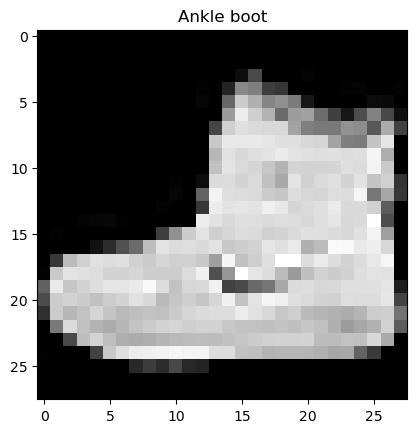

In [8]:
display_image(0)

# Standardization

We now separately standardize each set above.

In [9]:
def standardize(X):
    mean = np.mean(X, axis=0)
    standard_deviation = np.std(X, axis=0)
    copy = np.array(X, copy = True, dtype = np.float64)
    return (copy - mean)/standard_deviation

In [10]:
X_train_standardized = standardize(X_train_raw)
X_validation_standardized = standardize(X_validation_raw)
X_test_standardized = standardize(X_test_raw)

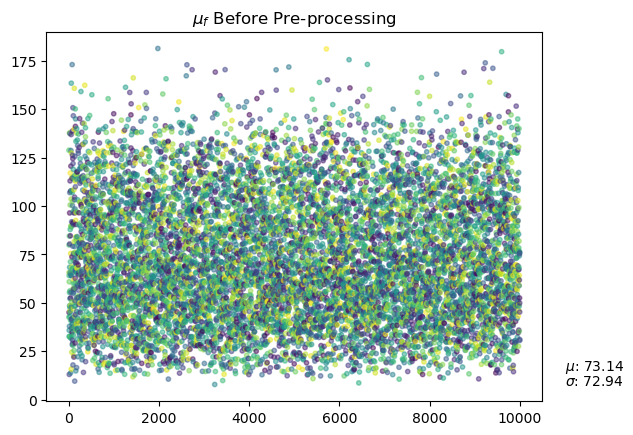

In [11]:
plt.scatter(np.arange(0, len(X_test_raw)), list(map(np.mean, X_test_raw)),  s=10,  alpha=.5, c = np.random.rand(X_test_raw.shape[0]))
plt.title(r"$\mu_f$ Before Pre-processing")
plt.text(11000, 15, r"$\mu$: 73.14")
plt.text(11000, 7.5, r"$\sigma$: 72.94")
plt.show()

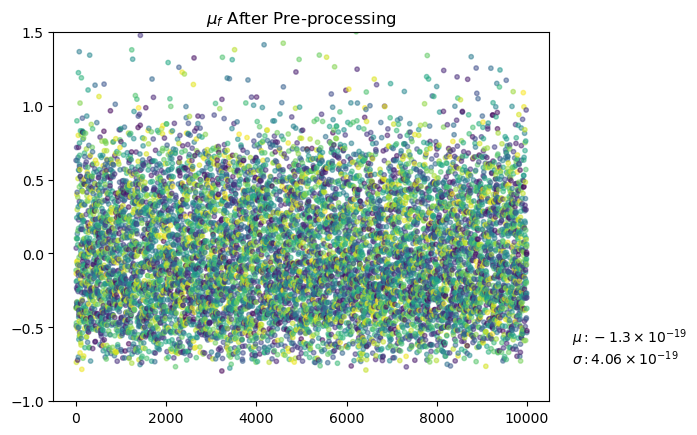

In [12]:
plt.scatter(np.arange(0, len(X_test_standardized)), list(map(np.mean, X_test_standardized)),  s=10,  alpha=.5, c = np.random.rand(X_test_standardized.shape[0]))
plt.title(r"$\mu_f$ After Pre-processing")
plt.text(11000, -.6, r"$\mu: -1.3 \times 10^{-19}$")
plt.text(11000, -.75, r"$\sigma: 4.06 \times 10^{-19}$")
plt.ylim(-1, 1.5)
plt.show()

### Mini-batch

Before we go code out the perceptron, we include a random split function. Let $N$ be the number of points in the training data set. Given a (small) integer $k$, we randomly partition the set $\{0, \cdots, N-1\}$ into subsets of exactly $k$ elements. In code, this means we will get a `list` of `list<int>` with each `list<int>` having exactly $k$ elements. If $k$ does not divide $n$, then we discard the last set.

In [13]:
def mini_batch(N,k):
    random_index_list = np.random.choice(N,N, replace= False)
    result = [list(random_index_list[x:x+k]) for x in range(0,N,k)]

    if len(result[-1]) != k:
        result.pop()

    return result

# Multi-layer Perceptron

In [14]:
class Layer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [15]:
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [16]:
class ReLULayer(Layer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [17]:
class LeakyReLULayer(Layer):
    def __init__(self, scalar):
        super().__init__()
        self.scalar = scalar
        
    def forward(self, x):
        self.gradient = np.where(x > 0, self.scalar, 0.0)
        return np.maximum(0, self.scalar*x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [18]:
class TanhLayer(Layer):
    #Incomplete
    pass

In [19]:
class SoftmaxOutputLayer(Layer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        copy = np.array(x, copy = True, dtype = np.float64)
        maximum = np.max(copy, axis=-1)[:, None]

        if np.all(maximum > 0):
            copy = copy - maximum

        exps = np.exp(copy)
        exps.astype(np.float64)
        exps[exps > 10**(200)] = 10**(200)
        exps[exps < 10**(-200)] = 10**(-200)
        
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [20]:
class Optimizer:
    def __init__(self, net):
        self.net = net

    def step(self, i):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient, i)

    def update(self, params, gradient, i):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net, learning_rate: float):
        super().__init__(net)
        self.learning_rate = learning_rate

    def update(self, params, gradient, i):
        for (p, g) in zip(params, gradient):
            p -= self.learning_rate * g.mean(axis=0) / (i+1)

In [21]:
class MultiLayerPerceptron:
    def __init__(self,*args: List[Layer]):
        self.layers = args
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
    
    def fit(self,X_train, Y_train, X_validation, Y_validation, learning_rate, max_ierations, batch_size):
        #Note: Y_train is in binary

        self.learning_rate = learning_rate
        self.max_iterations = max_ierations
        self.batch_size = batch_size
        self.losses = []
        self.validation_loss = []
        self.accuracies = []
        self.best_accuracy = 0

        self.X_train = X_train
        self.Y_train = Y_train
        self.X_validation = X_validation
        self.Y_validation = Y_validation

        N = len(X_train)
        self.batches = mini_batch(N, self.batch_size)
        self.optimizer = GradientDescentOptimizer(net = self , learning_rate = self.learning_rate)

        self.train()

    def train(self):
        for i in tqdm(range(self.max_iterations)):
            
            if i % 10 == 0:
                loss,accuracy = self.validate()
                self.accuracies.append(accuracy)
                self.validation_loss.append(loss)
                if accuracy > self.best_accuracy:
                    self.best_accuracy = accuracy

            X = self.X_train[self.batches[i]]
            Y = self.Y_train[self.batches[i]]

            probabilities = self.forward(X)
            loss = self.evaluate_loss(Y = Y, probabilities= probabilities)
            self.losses.append(loss)
            self.backward(Y)
            self.optimizer.step(i)
    
    def validate(self):
        probabilities, Y_hat = self.predict(self.X_validation)
        
        loss = self.evaluate_loss(Y = label_to_binary(self.Y_validation), probabilities=probabilities)
        accuracy = self.evaluate_acc(Y = self.Y_validation, Y_hat = Y_hat)

        return loss,accuracy
    
    def evaluate_loss(self, Y, probabilities):
        log_prediction = np.log(probabilities)

        log_prediction[log_prediction < -10**(100)] = - 10**(100)

        return -(Y * log_prediction).sum(axis=-1).mean()

    def make_final_classification(self, probabilities):
        '''
Let an N times k_T array probabilities be given. Assume that the last layer is softmax. 
We take the element of greatest probability as our final prediction results.
        '''
        classification_binary = np.zeros(probabilities.shape, dtype = np.uint8)
        classification_label = np.zeros((probabilities.shape[0]), dtype = np.uint8)
        for i in range(0, probabilities.shape[0]):
            max_prob = np.max(probabilities[i])
            for j in range(0, probabilities.shape[1]):
                if probabilities[i][j] == max_prob:
                    classification_binary[i][j] = 1
                    classification_label[i] = j
                    break
        
        return classification_binary, classification_label

    def predict(self, X):
        probabilities = self.forward(X)
        classification_binary, classification_label = self.make_final_classification(probabilities)
        return probabilities, classification_label
    
    def evaluate_acc(self, Y, Y_hat):
        #Remark: it is assumed that Y is in label and Y_hat = classification_in_label
        N = Y.shape[0]
        difference = Y - Y_hat

        nonzero = np.count_nonzero(difference)
        return 1-nonzero/N
    
    def visualize_accuracy(self, title):
        length = len(self.accuracies)
        x_axis = [10*u for u in range(0, length)]

        plt.plot(x_axis, self.accuracies)
 
        plt.title(title)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Accuracy')
        plt.show()
    
    def visualize_loss(self, title):
        plt.plot(self.losses)
        plt.title(title)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Cross Entropy")
    
    def visualize_validation_loss(self, title):
        length = len(self.validation_loss)
        x_axis = [10*u for u in range(0, length)]

        plt.plot(x_axis, self.validation_loss)
 
        plt.title(title)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Cross Entropy')
        plt.show()

In [22]:
C = 10
D = X_train_standardized.shape[-1]

no_hidden = MultiLayerPerceptron(
    LinearLayer(D, C),
    SoftmaxOutputLayer()
)

no_hidden.fit(
X_train = X_train_standardized, 
Y_train = Y_train_binary, 
X_validation= X_validation_standardized,
Y_validation= Y_validation_label,
learning_rate = 5e-2, max_ierations = 1000, batch_size = 15)

100%|██████████| 1000/1000 [00:04<00:00, 225.67it/s]


In [23]:
_,Y_hat = no_hidden.predict(X_test_standardized)
accuracy = no_hidden.evaluate_acc(Y = Y_test_label, Y_hat = Y_hat)
print("Testing accuracy:")
print(accuracy)

Testing accuracy:
0.2238


Minimum cross entropy loss:
6.023604046759017
Best Trainiung Accuracy:
0.21699999999999997


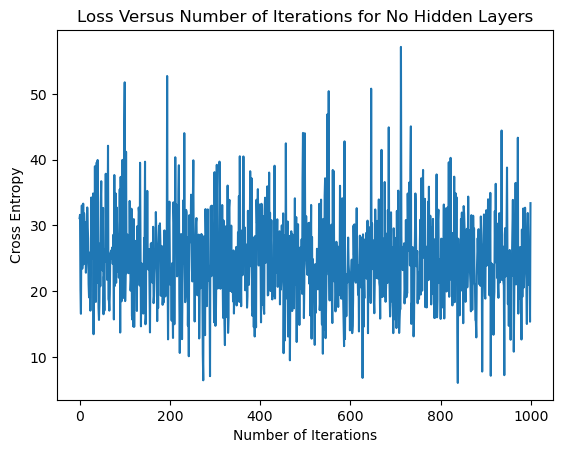

In [24]:
no_hidden.visualize_loss("Loss Versus Number of Iterations for No Hidden Layers")

print("Minimum cross entropy loss:")
print(min(no_hidden.losses))
print("Best Trainiung Accuracy:")
print(no_hidden.best_accuracy)

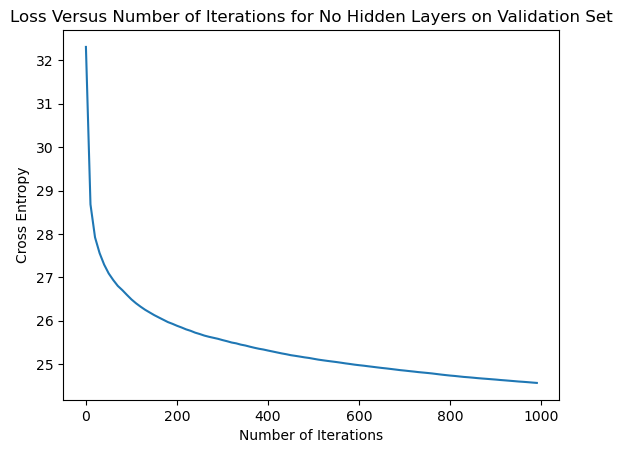

In [25]:
no_hidden.visualize_validation_loss("Loss Versus Number of Iterations for No Hidden Layers on Validation Set")

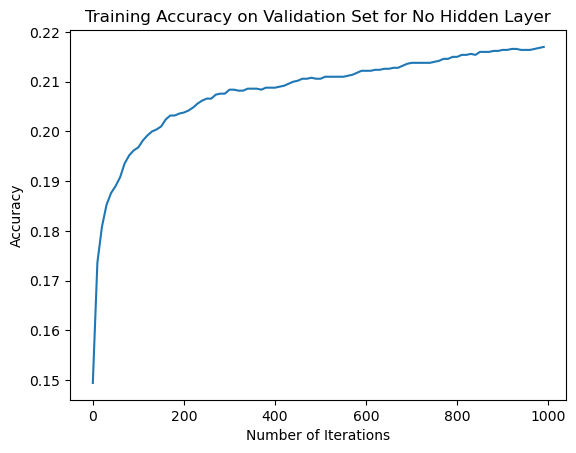

In [26]:
no_hidden.visualize_accuracy("Training Accuracy on Validation Set for No Hidden Layer")

In [27]:
C = 10
hidden_unit = 128
D = X_train_standardized.shape[-1]

single_relu = MultiLayerPerceptron(
    LinearLayer(D, hidden_unit),
    ReLULayer(),
    LinearLayer(hidden_unit, C),
    SoftmaxOutputLayer()
)

single_relu.fit(
X_train = X_train_standardized, 
Y_train = Y_train_binary, 
X_validation= X_validation_standardized,
Y_validation= Y_validation_label,
learning_rate = 5e-2, max_ierations = 1000, batch_size = 15)

100%|██████████| 1000/1000 [00:17<00:00, 58.76it/s]


In [28]:
_,Y_hat = single_relu.predict(X_test_standardized)
accuracy = single_relu.evaluate_acc(Y = Y_test_label, Y_hat = Y_hat)
print("Testing accuracy:")
print(accuracy)

Testing accuracy:
0.5488


Minimum cross entropy loss:
3.329099016696772
Best Training Accuracy:
0.5478000000000001


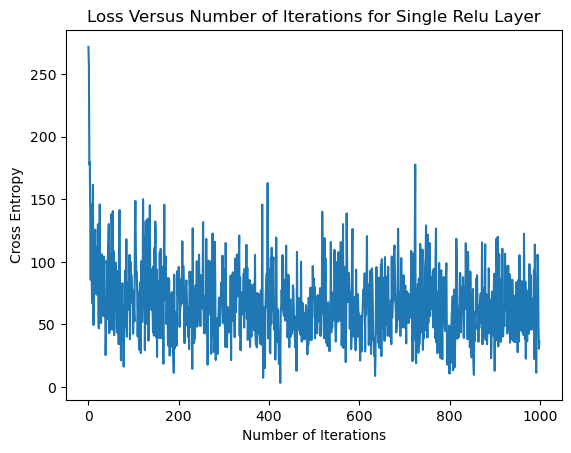

In [29]:
single_relu.visualize_loss("Loss Versus Number of Iterations for Single Relu Layer")

print("Minimum cross entropy loss:")
print(min(single_relu.losses))
print("Best Training Accuracy:")
print(single_relu.best_accuracy)

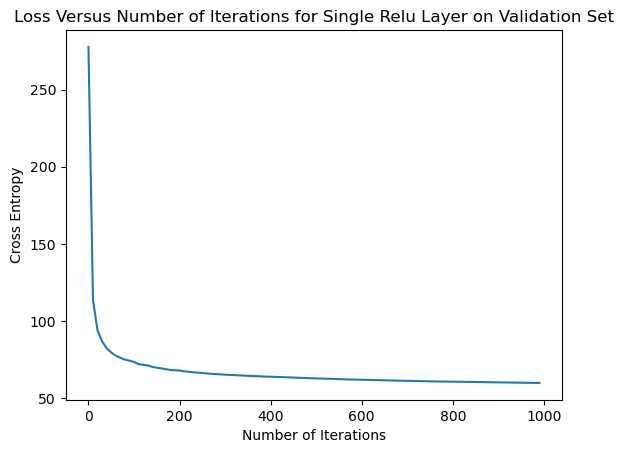

In [30]:
single_relu.visualize_validation_loss("Loss Versus Number of Iterations for Single Relu Layer on Validation Set")

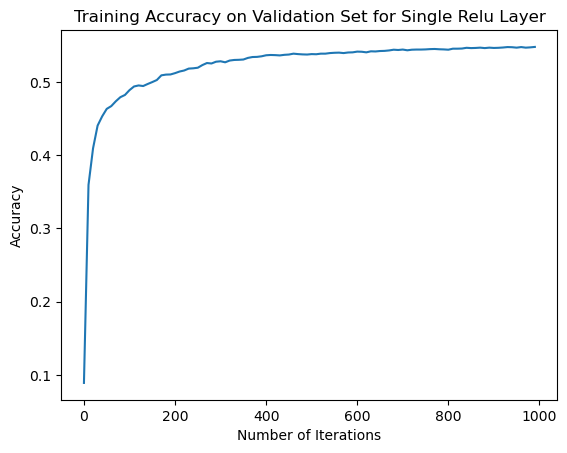

In [31]:
single_relu.visualize_accuracy("Training Accuracy on Validation Set for Single Relu Layer")

In [32]:
C = 10
hidden_units = 128
D = X_train_standardized.shape[-1]

double_relu = MultiLayerPerceptron(
    LinearLayer(D, hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, C),
    SoftmaxOutputLayer()
)

double_relu.fit(
X_train = X_train_standardized, 
Y_train = Y_train_binary, 
X_validation= X_validation_standardized,
Y_validation= Y_validation_label,
learning_rate = 1e-2, max_ierations = 2000, batch_size = 15)

100%|██████████| 2000/2000 [00:42<00:00, 46.94it/s]


In [33]:
_,Y_hat = double_relu.predict(X_test_standardized)
accuracy = double_relu.evaluate_acc(Y = Y_test_label, Y_hat = Y_hat)
print("Testing Accuracy:")
print(accuracy)

Testing Accuracy:
0.5958


Minimum cross entropy loss:
10.18419095052203
Best Training Accuracy:
0.6073999999999999


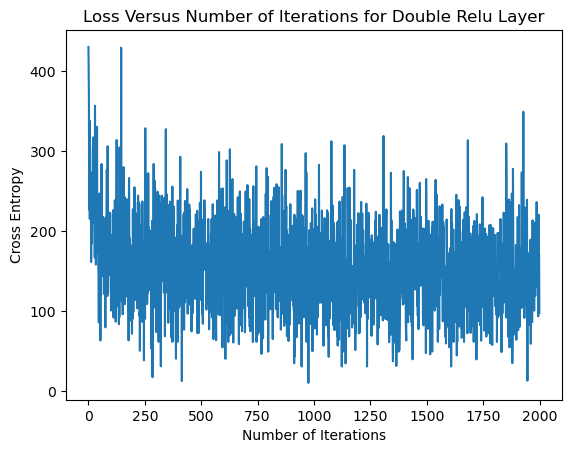

In [34]:
double_relu.visualize_loss("Loss Versus Number of Iterations for Double Relu Layer")

print("Minimum cross entropy loss:")
print(min(double_relu.losses))
print("Best Training Accuracy:")
print(double_relu.best_accuracy)

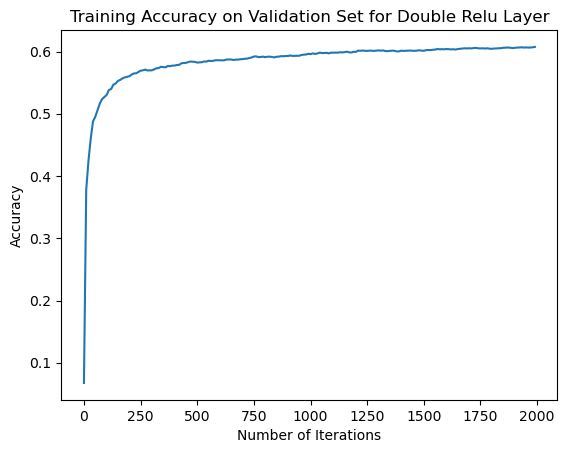

In [35]:
double_relu.visualize_accuracy("Training Accuracy on Validation Set for Double Relu Layer")

In [36]:
C = 10
hidden_units = 128
D = X_train_standardized.shape[-1]
scalar = 0.5

double_leaky = MultiLayerPerceptron(
    LinearLayer(D, hidden_units),
    LeakyReLULayer(scalar),
    LinearLayer(hidden_units, hidden_units),
    LeakyReLULayer(scalar),
    LinearLayer(hidden_units, C),
    SoftmaxOutputLayer()
)

double_leaky.fit(
X_train = X_train_standardized, 
Y_train = Y_train_binary, 
X_validation= X_validation_standardized,
Y_validation= Y_validation_label,
learning_rate = 1e-2, max_ierations = 2000, batch_size = 15)

100%|██████████| 2000/2000 [00:43<00:00, 45.51it/s]


In [37]:
_,Y_hat = double_leaky.predict(X_test_standardized)
accuracy = double_leaky.evaluate_acc(Y = Y_test_label, Y_hat = Y_hat)
print("Testing Accuracy:")
print(accuracy)

Testing Accuracy:
0.4617


Minimum cross entropy loss:
21.98793803536843
Best Training Accuracy:
0.45599999999999996


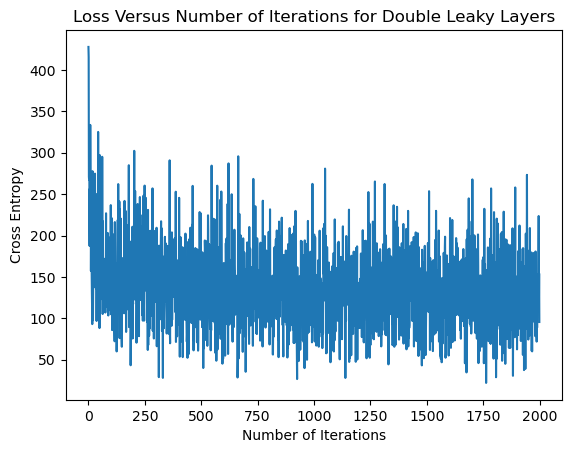

In [38]:
double_leaky.visualize_loss("Loss Versus Number of Iterations for Double Leaky Layers")

print("Minimum cross entropy loss:")
print(min(double_leaky.losses))
print("Best Training Accuracy:")
print(double_leaky.best_accuracy)

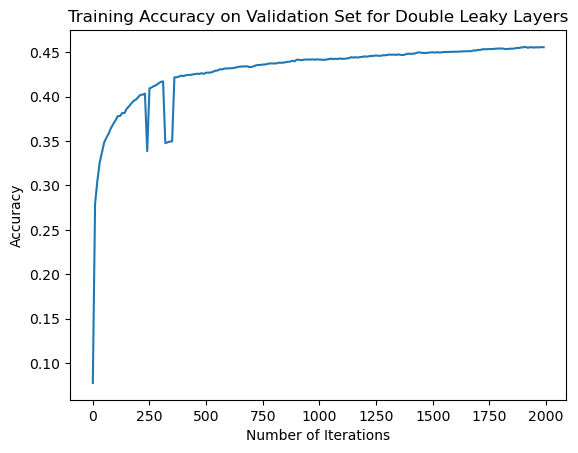

In [39]:
double_leaky.visualize_accuracy("Training Accuracy on Validation Set for Double Leaky Layers")